In [24]:
# changing working directory (Google colab)
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/ML/TrojanGuard/code

ModuleNotFoundError: No module named 'google'

In [ ]:
# for saving changes to github (Google colab)
%cd ..
!git config --global user.email  "abdosalm555@gmail.com"
!git config --global user.name "abdosalem490"
!git add .
!git commit -am "[UPDATE]: added google colab cells"
!git push
%cd code

/
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
[Errno 2] No such file or directory: 'code'
/


In [3]:
# add the needed imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
import sys
import copy
import math
import time
from prettytable import PrettyTable

In [3]:
# read the dataset
df = pd.read_csv("Trojan_Detection_dataset.csv")

# remove leading and trailing whitespaces from column names
df = df.rename(columns=lambda x: x.strip())

# list of protocol name where every index represents the protocol number
# protocol_names = ["HOPOPT", "ICMP", "IGMP", "GGP", "IPv4", "ST", "TCP", "CBT", "EGP", "IGP", "BBN-RCC-MON", "NVP-II", "PUP", "ARGUS (deprecated)", "EMCON", "XNET", "CHAOS", "UDP"]

# column_descriptions = {
#     "record_id": "represents the id of the record",
#     "Flow ID": "written as <source/destination ip> - <source/destination ip> - <destination/source port> - <destination/source port> - <protocol>.",
#     "Source IP": "IP address of source",
#     "Source Port": "Port number of source",
#     "Destination IP": "IP address of destination",
#     "Destination Port": "Port number of destination",
#     "Protocol": "name protocol used, refer to @protocol_names list",
#     "Timestamp": "digital record of the date and time when the frame transmitted",
#     "Flow Duration": "the time elapsed between receiving the first and last packets in the flow",
#     "Total Fwd Packets": ""
# }


# remove Timestamp, Flow ID, Class and record_id columns
global_labels = df['Class']
df = df.drop(columns=['Timestamp', 'Flow ID', 'Class', 'record_id'])

# split the dataset into 75% training, 25% testing
X_train, X_test, Y_train, Y_test = train_test_split(df, global_labels, test_size=0.25, random_state=121, shuffle=True, stratify=global_labels)
# Note: stratify keeps the proportion of labels same for the result train and test data


# reset the indexes of the data after splitting as the data keeps its original index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

# make a copy of the training data so that to be compared with the results after modification
X_traing_unModified = copy.deepcopy(X_train)
Y_traing_unModified = copy.deepcopy(Y_train)
X_testing_unModified = copy.deepcopy(X_test)
Y_testing_unModified = copy.deepcopy(Y_test)


In [4]:
# Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.
X_train.describe()
# df["Flow Duration"].describe()

Source Port  Destination Port       Protocol  Flow Duration  \
count  133111.000000     133111.000000  133111.000000   1.331110e+05   
mean    38677.247267       5728.698402       8.291576   1.162712e+07   
std     18396.808663      15112.313587       4.537692   2.301241e+07   
min         0.000000          0.000000       0.000000   2.000000e+00   
25%     34210.000000         80.000000       6.000000   4.712450e+04   
50%     43105.000000        443.000000       6.000000   4.890110e+05   
75%     52145.000000        443.000000       6.000000   1.062112e+07   
max     65530.000000      64872.000000      17.000000   1.199991e+08   

       Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  \
count      133111.000000           133111.000000                133111.000000   
mean            6.756699                9.815440                   812.059507   
std            30.880565              108.268071                  5990.733156   
min             1.000000                0.000000                     0.000000   
25%             1.000000                0.000000                     0.000000   
50%             2.000000                1.000000                    31.000000   
75%             5.000000                4.000000                   456.000000   
max          4502.000000            12951.000000                846614.000000   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
count                 1.331110e+05          133111.000000   
mean                  1.009982e+04             230.863287   
std                   1.545215e+05             392.282188   
min                   0.000000e+00               0.000000   
25%                   0.000000e+00               0.000000   
50%                   3.100000e+01              31.000000   
75%                   4.950000e+02             360.000000   
max                   1.868497e+07            1460.000000   

       Fwd Packet Length Min  ...  act_data_pkt_fwd  min_seg_size_forward  \
count          133111.000000  ...     133111.000000         133111.000000   
mean               13.434682  ...          1.681491             27.804892   
std                68.885089  ...          6.886006              6.661768   
min                 0.000000  ...          0.000000             -1.000000   
25%                 0.000000  ...          0.000000             20.000000   
50%                 0.000000  ...          0.000000             32.000000   
75%                19.000000  ...          1.000000             32.000000   
max              1460.000000  ...        586.000000             60.000000   

        Active Mean    Active Std    Active Max    Active Min     Idle Mean  \
count  1.331110e+05  1.331110e+05  1.331110e+05  1.331110e+05  1.331110e+05   
mean   1.422540e+05  2.045536e+04  1.618713e+05  1.266040e+05  4.527302e+06   
std    7.846408e+05  2.471200e+05  8.803947e+05  7.562493e+05  1.541794e+07   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    3.059421e+07  1.599951e+07  3.059421e+07  3.059421e+07  1.197736e+08   

           Idle Std      Idle Max      Idle Min  
count  1.331110e+05  1.331110e+05  1.331110e+05  
mean   3.960936e+05  4.876552e+06  4.225439e+06  
std    3.209321e+06  1.625309e+07  1.504325e+07  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  0.000000e+00  
max    7.445182e+07  1.197736e+08  1.197736e+08  

[8 rows x 80 columns]

In [5]:
# prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133111 entries, 0 to 133110
Data columns (total 82 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Source IP                    133111 non-null  object 
 1   Source Port                  133111 non-null  int64  
 2   Destination IP               133111 non-null  object 
 3   Destination Port             133111 non-null  int64  
 4   Protocol                     133111 non-null  int64  
 5   Flow Duration                133111 non-null  int64  
 6   Total Fwd Packets            133111 non-null  int64  
 7   Total Backward Packets       133111 non-null  int64  
 8   Total Length of Fwd Packets  133111 non-null  int64  
 9   Total Length of Bwd Packets  133111 non-null  int64  
 10  Fwd Packet Length Max        133111 non-null  int64  
 11  Fwd Packet Length Min        133111 non-null  int64  
 12  Fwd Packet Length Mean       133111 non-null  float64
 13 

In [6]:
X_train.head(10).T

0               1           2               3  \
Source IP             10.42.0.42      10.42.0.42  10.42.0.42      10.42.0.42   
Source Port                48983           34014        1976           60140   
Destination IP    123.125.29.220  172.217.12.202   10.42.0.1  202.77.129.161   
Destination Port              80             443          53              80   
Protocol                       6               6          17               6   
...                          ...             ...         ...             ...   
Active Min                     0         1955451           0               0   
Idle Mean                    0.0      58576706.0         0.0             0.0   
Idle Std                     0.0             0.0         0.0             0.0   
Idle Max                       0        58576706           0               0   
Idle Min                       0        58576706           0               0   

                               4               5           6              7  \
Source IP            10.42.0.211      10.42.0.42  10.42.0.42     10.42.0.42   
Source Port                57976           57903       60833          44359   
Destination IP    216.58.219.227  63.250.200.101   10.42.0.1  174.35.73.148   
Destination Port             443             443          53             80   
Protocol                       6               6          17              6   
...                          ...             ...         ...            ...   
Active Min                241715               0           0              0   
Idle Mean             14201349.0             0.0         0.0            0.0   
Idle Std                     0.0             0.0         0.0            0.0   
Idle Max                14201349               0           0              0   
Idle Min                14201349               0           0              0   

                               8           9  
Source IP             10.42.0.42  10.42.0.42  
Source Port                34505       22638  
Destination IP    202.77.129.150   10.42.0.1  
Destination Port              80          53  
Protocol                       6          17  
...                          ...         ...  
Active Min                     0           0  
Idle Mean                    0.0         0.0  
Idle Std                     0.0         0.0  
Idle Max                       0           0  
Idle Min                       0           0  

[82 rows x 10 columns]

<Figure size 640x480 with 0 Axes>

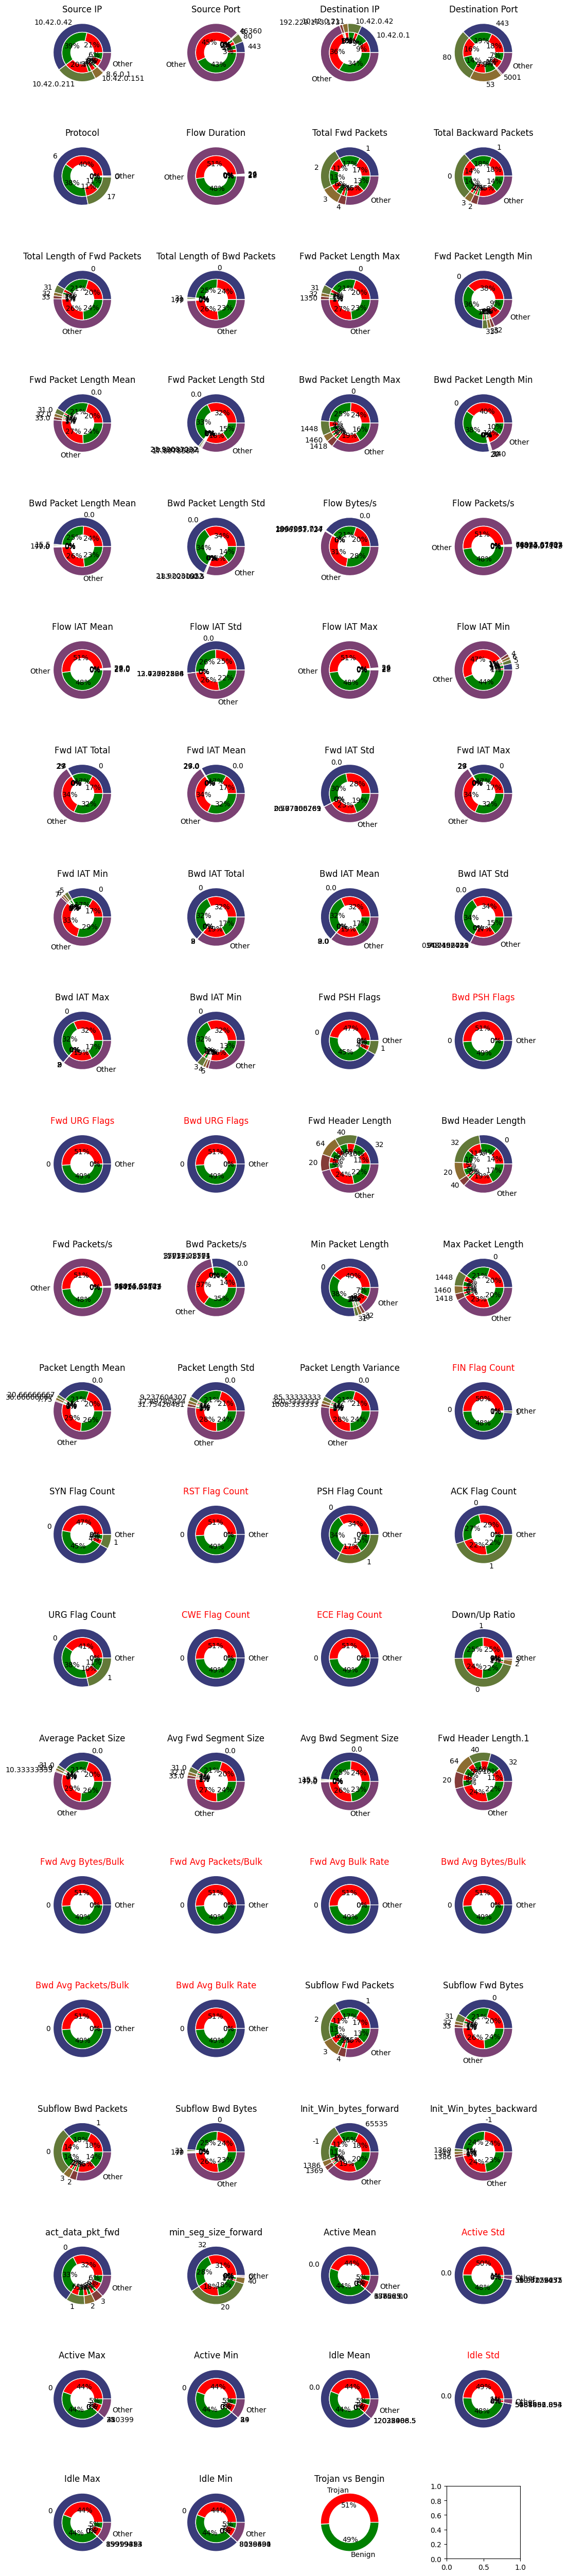

In [7]:
# get the total number of Trojan and benign classes from training data
Trojan_total = Y_train.value_counts().iloc[0]
Benign_total = Y_train.value_counts().iloc[1]

# store in it the indexes of the columns that represents the features that aren't important (15 features)
indexes_of_columns_to_dropped = [35, 36, 37, 47, 49, 53, 54, 60, 61, 62, 63, 64, 65, 75, 79]

# visualize features in pie chart manner
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(21, 4, figsize=(10,50))
fig.tight_layout(h_pad=5, w_pad=5)

j = 0
for series_name, series in X_train.items():

#     print(f"{j//4}, {j%4}, {series_name}")

    # to handle the case when the number of unique values are less than 5
    largest_n_num = 4
    if len(series.value_counts()) <= largest_n_num:
        largest_n_num = len(series.value_counts())

    # get the largest IP addresses (default = 4)
    largest_4 = series.value_counts().nlargest(largest_n_num)
    # add fifth element which represents the other IP address
    largest_4.loc['Other'] = len(series)-sum(largest_4.values)

    # plot 4 biggest values for each feature and how much every class resemble this feature
    cmap = plt.colormaps["tab20b"]
    outer_colors = cmap(np.arange(5)*4)
    inner_colors = cmap([1, 2, 5, 6, 9, 10, 14, 15, 18, 19])

    # count number of Trojans and Benigns for each value of the current feature
    vals = []
    Trojan_list = []
    Benign_list = []

    for i in range(0, largest_n_num):
        torjan_c = len(X_train.loc[(series==largest_4.index[i]) & (Y_train=="Trojan")])
        benign_c = len(X_train.loc[(series==largest_4.index[i]) & (Y_train=="Benign")])
        Trojan_list.append(torjan_c)
        Benign_list.append(benign_c)
        vals.append(torjan_c)
        vals.append(benign_c)


    # add the value for the others
    others_trojan = Trojan_total-sum(Trojan_list)
    others_benign = Benign_total-sum(Benign_list)
    vals.append(others_trojan)
    vals.append(others_benign)

    colour = "black"
    if j in indexes_of_columns_to_dropped: # indexes of features to be neglected
        colour = "red"
    
    ax[j//4][j%4].set_title(series_name, color=colour)
    ax[j//4][j%4].pie(largest_4.values, labels=largest_4.index, radius=1, colors=outer_colors,
           wedgeprops=dict(width=0.3, edgecolor='w'))

    # green is not trojan, red is trojan
    ax[j//4][j%4].pie(vals, radius=0.7, colors=["red", "green"],
           wedgeprops=dict(width=0.3, edgecolor='w'), autopct='%1.0f%%')

    # move to the next cell
    j += 1

# plot number of benign against trojan
ax[j//4][j%4].set_title("Trojan vs Bengin")
ax[j//4][j%4].pie(Y_train.value_counts().values, labels=Y_train.value_counts().index, radius=1, colors=["red", "green"],
       wedgeprops=dict(width=0.3, edgecolor='w'), autopct='%1.0f%%')

plt.show()



In [8]:
# thus said we need to remove the highlighted features above as the feature is having a constant value nearly distributed equally between the 2 classes, so it's not important (can be neglected)
X_train.drop(X_train.columns[indexes_of_columns_to_dropped], axis=1, inplace=True)

X_train

Source IP  Source Port  Destination IP  Destination Port  \
0          10.42.0.42        48983  123.125.29.220                80   
1          10.42.0.42        34014  172.217.12.202               443   
2          10.42.0.42         1976       10.42.0.1                53   
3          10.42.0.42        60140  202.77.129.161                80   
4         10.42.0.211        57976  216.58.219.227               443   
...               ...          ...             ...               ...   
133106    10.42.0.211        35144   209.10.120.26                80   
133107     10.42.0.42        55255  123.59.190.237                80   
133108     10.42.0.42        47678  104.244.43.227               443   
133109     10.42.0.42        58449   172.217.11.14               443   
133110  77.234.44.201           80      10.42.0.42             52734   

        Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              6         290032                  1                       1   
1              6       60631432                 88                      98   
2             17        1172343                  1                       1   
3              6       30484454                  2                       2   
4              6       14443064                  9                       7   
...          ...            ...                ...                     ...   
133106         6         106297                  3                       2   
133107         6       10487111                  3                       1   
133108         6       96563064                  3                       0   
133109         6       98486799                 11                      10   
133110         6           2196                  1                       1   

        Total Length of Fwd Packets  Total Length of Bwd Packets  ...  \
0                                 0                            0  ...   
1                              4826                       127271  ...   
2                                33                          153  ...   
3                                 0                          106  ...   
4                               504                         4755  ...   
...                             ...                          ...  ...   
133106                          342                          174  ...   
133107                            0                            0  ...   
133108                            0                            0  ...   
133109                         1260                         5048  ...   
133110                            0                            0  ...   

        Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  \
0                         1386                      137                 0   
1                        65535                      439                 7   
2                           -1                       -1                 0   
3                        65535                      115                 0   
4                        65535                      349                 2   
...                        ...                      ...               ...   
133106                   65535                      512                 1   
133107                   65535                     8190                 0   
133108                    1731                       -1                 0   
133109                   65535                      362                 4   
133110                       1                     1386                 0   

        min_seg_size_forward  Active Mean  Active Max  Active Min   Idle Mean  \
0                         20          0.0           0           0         0.0   
1                         32    1955451.0     1955451     1955451  58576706.0   
2                         20          0.0           0           0         0.0   
3                         20          0.0           0           0         0.0   
4  

In [9]:
# convert IP address into a number from the format(A.B.C.D) to (AAABBBCCCDDD)
def convertIP(IP_addr):
    IP_list = [int(x) for x in IP_addr.split(".")]
    IP_num = sum([x * (10**(3*(3-i))) for i, x in enumerate(IP_list)])
    return IP_num

# apply the conversion
X_train['Source IP'] = X_train['Source IP'].apply(convertIP)
X_train['Destination IP'] = X_train['Destination IP'].apply(convertIP)

X_traing_unModified['Source IP'] = X_traing_unModified['Source IP'].apply(convertIP)
X_traing_unModified['Destination IP'] = X_traing_unModified['Destination IP'].apply(convertIP)

X_train.head(5)

Source IP  Source Port  Destination IP  Destination Port  Protocol  \
0  10042000042        48983    123125029220                80         6   
1  10042000042        34014    172217012202               443         6   
2  10042000042         1976     10042000001                53        17   
3  10042000042        60140    202077129161                80         6   
4  10042000211        57976    216058219227               443         6   

   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         290032                  1                       1   
1       60631432                 88                      98   
2        1172343                  1                       1   
3       30484454                  2                       2   
4       14443064                  9                       7   

   Total Length of Fwd Packets  Total Length of Bwd Packets  ...  \
0                            0                            0  ...   
1                         4826                       127271  ...   
2                           33                          153  ...   
3                            0                          106  ...   
4                          504                         4755  ...   

   Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  \
0                    1386                      137                 0   
1                   65535                      439                 7   
2                      -1                       -1                 0   
3                   65535                      115                 0   
4                   65535                      349                 2   

   min_seg_size_forward  Active Mean  Active Max  Active Min   Idle Mean  \
0                    20          0.0           0           0         0.0   
1                    32    1955451.0     1955451     1955451  58576706.0   
2                    20          0.0           0           0         0.0   
3                    20          0.0           0           0         0.0   
4                    32     241715.0      241715      241715  14201349.0   

   Idle Max  Idle Min  
0         0         0  
1  58576706  58576706  
2         0         0  
3         0         0  
4  14201349  14201349  

[5 rows x 67 columns]

In [17]:
# create an array whose size is same as the length of the data
voting = np.zeros(len(X_train), dtype=np.int32)


<Figure size 640x480 with 0 Axes>

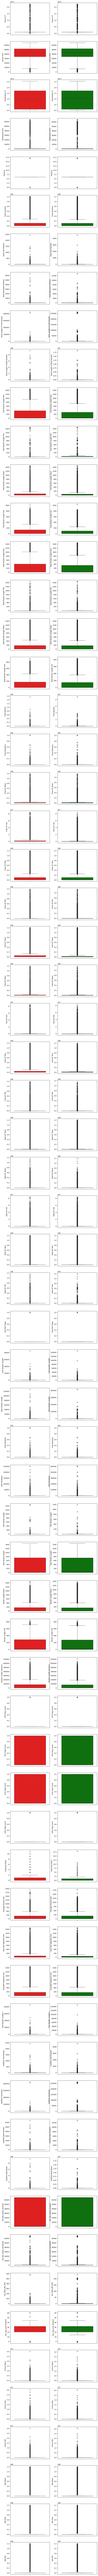

[ 2 38  6 ...  8 40  8]


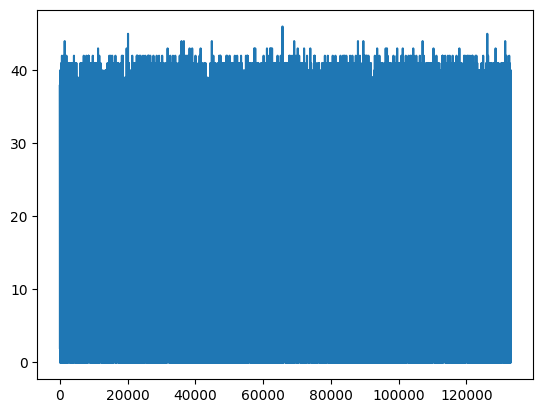

In [18]:
# apply box-plot to the features to get the IQR and vote for which points to be removed

# separate the trojan and the benign data
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(67, 2, figsize=(10,300))

i = 0
for series_name, series in Trojan_data.items():
  # we chose the number of bins=30 because the default value "auto (creating number of bins equal to number of unique values)" was taking too much time (61 minute for plotting only 18 feature)
  sns.boxplot(Trojan_data[series_name], ax=ax[i][0], color="red")
  sns.boxplot(Benign_data[series_name], ax=ax[i][1], color="green")
  print(f"processing feature number {i}", end = "\r")
  i += 1

  # get the Q1 and Q3 quantiles for Trojan
  Q1 = Trojan_data[series_name].quantile(0.25)
  Q3 = Trojan_data[series_name].quantile(0.75)
  IQR = Q3 - Q1

  # get which points to be removed and vote for it 
  outliers = (Trojan_data[series_name] < Q1 - IQR) | (Trojan_data[series_name] > Q3 + IQR)

  # vote for it if it's True
  for index, value in outliers.items():
    if value:
      voting[index] += 1


  # get the Q1 and Q3 quantiles for Benign
  Q1 = Benign_data[series_name].quantile(0.25)
  Q3 = Benign_data[series_name].quantile(0.75)
  IQR = Q3 - Q1

  # get which points to be removed and vote for it 
  outliers = (Benign_data[series_name] < Q1 - IQR) | (Benign_data[series_name] > Q3 + IQR)

  # vote for it if it's True
  for index, value in outliers.items():
    if value:
      voting[index] += 1


plt.show()


plt.plot(voting)
print(voting)


<Figure size 640x480 with 0 Axes>

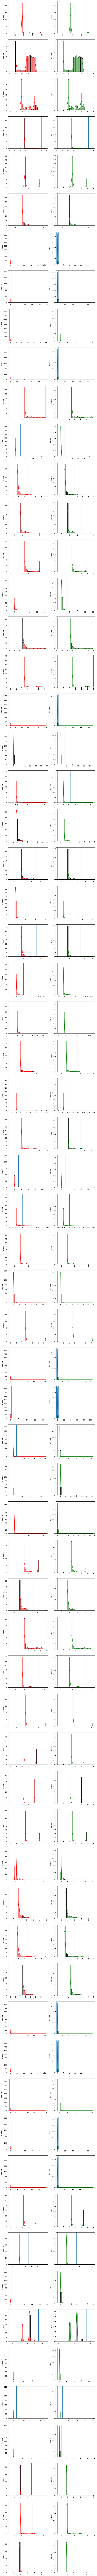

[10 40  6 ...  8 40  8]


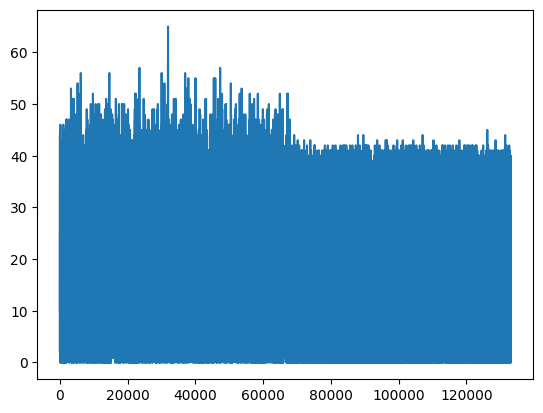

In [19]:
# apply standard scalar whose equation is "(x - mean) / std" and check for Z-score where if any point has the value < -3 or > 3 then we will vote for it

# separate the trojan and the benign data
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]


plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(82 - len(indexes_of_columns_to_dropped), 2, figsize=(10,300))


i = 0
for series_name, series in Trojan_data.items():

  # apply standard-scalar on each feature before plotting
  Trojan_normalized = StandardScaler().fit_transform(Trojan_data[series_name].values.reshape(-1, 1)).reshape(-1)
  Benign_normalized = StandardScaler().fit_transform(Benign_data[series_name].values.reshape(-1, 1)).reshape(-1)

  # get which points to be removed and vote for it (Trojan)
  outliers = (Trojan_normalized < -3) | (Trojan_normalized > 3)

  # vote for it if it's True
  for index in np.where(outliers == True):
      voting[index] += 1

  # get which points to be removed and vote for it (Benign)
  outliers = (Benign_normalized < -3) | (Benign_normalized > 3)

  # vote for it if it's True
  for index in np.where(outliers == True):
      voting[index] += 1
    

  # we chose the number of bins=30 because the default value "auto (creating number of bins equal to number of unique values)" was taking too much time (61 minute for plotting only 18 feature)
  sns.histplot(Trojan_normalized, stat="percent", kde=True, ax=ax[i][0], bins=30, color="red")
  sns.histplot(Benign_normalized, stat="percent", kde=True, ax=ax[i][1], bins=30, color="green")

  # plot the lines before which we will vote for the points to be outlier
  ax[i][0].axvline(x=-3)
  ax[i][1].axvline(x=-3)

  # plot the lines after which we will vote for the points to be outlier
  ax[i][0].axvline(x=3)
  ax[i][1].axvline(x=3)

  print(f"processing feature number {i}", end = "\r")
  i += 1


plt.show()



plt.plot(voting)
print(voting)

number of points in 1st cluster = 119544
number of points in 2nd cluster = 13567
percentage of cluster 2 to cluster 1 = 0.11348959378973432


<Figure size 640x480 with 0 Axes>

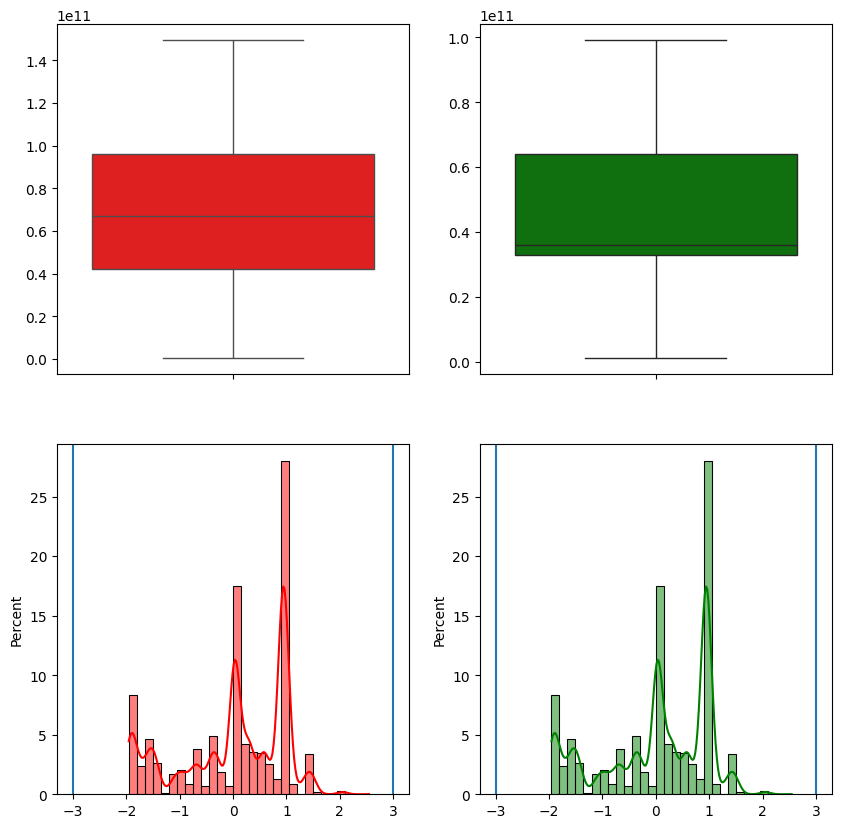

[10 40  6 ...  8 40  8]


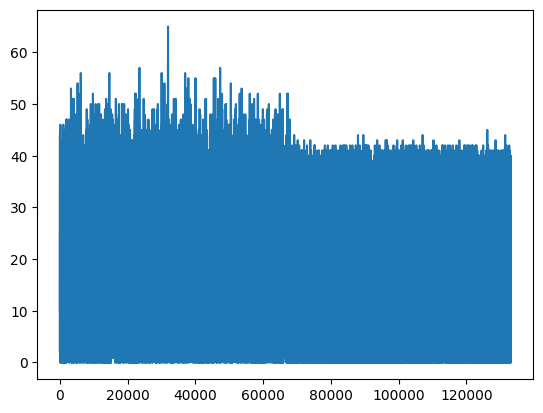

In [20]:
# using Kmeans to visualize and decided which point to remove it given its distance from the center
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_train.values)
distances = kmeans.transform(X_train.values)

# extract the distances for each near cluster alone
distances_clusters = [[], []]

for i in range(0, len(kmeans.labels_)):
    label = kmeans.labels_[i]
    distances_clusters[label].append(distances[i][label])

# plot distances for the 2 classes each on a graph
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(2, 2, figsize=(10,10))


# plot for IQR range
sns.boxplot(distances_clusters[0], ax=ax[0][0], color="red")
sns.boxplot(distances_clusters[1], ax=ax[0][1], color="green")

# compute quantiles
Q1 = np.quantile(distances_clusters[0], 0.25)
Q3 = np.quantile(distances_clusters[0], 0.75)
IQR = Q3 - Q1

# get which points to be removed and vote for it 
outliers = (distances_clusters[0] < Q1 - IQR) | (distances_clusters[0] > Q3 + IQR)

# vote for it if it's True
for index in outliers:
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it 
outliers = (distances_clusters[1] < Q1 - IQR) | (distances_clusters[1] > Q3 + IQR)

# vote for it if it's True
for index in outliers:
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# compute Z-score
# apply standard-scalar on each feature before plotting
distances0_normalized = StandardScaler().fit_transform(np.array(distances_clusters[0]).reshape(-1, 1)).reshape(-1)
distances1_normalized = StandardScaler().fit_transform(np.array(distances_clusters[1]).reshape(-1, 1)).reshape(-1)

# get which points to be removed and vote for it (Benign)
outliers = (distances0_normalized < -3) | (distances0_normalized > 3)

# vote for it if it's True
for index in np.where(outliers == True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it (Benign)
outliers = (distances1_normalized < -3) | (distances1_normalized > 3)

# vote for it if it's True
for index in np.where(outliers == True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# plot the distribution of the distances
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][0], bins=30, color="red")
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][1], bins=30, color="green")

# plot the lines before which we will vote for the points to be outlier
ax[1][0].axvline(x=-3)
ax[1][1].axvline(x=-3)

# plot the lines after which we will vote for the points to be outlier
ax[1][0].axvline(x=3)
ax[1][1].axvline(x=3)

print(f"number of points in 1st cluster = {len(distances_clusters[0])}")
print(f"number of points in 2nd cluster = {len(distances_clusters[1])}")
print(f"percentage of cluster 2 to cluster 1 = {len(distances_clusters[1]) / len(distances_clusters[0])}")
plt.show()


plt.plot(voting)
print(voting)

number of points in 1st cluster = 68012
number of points in 2nd cluster = 65099


<Figure size 640x480 with 0 Axes>

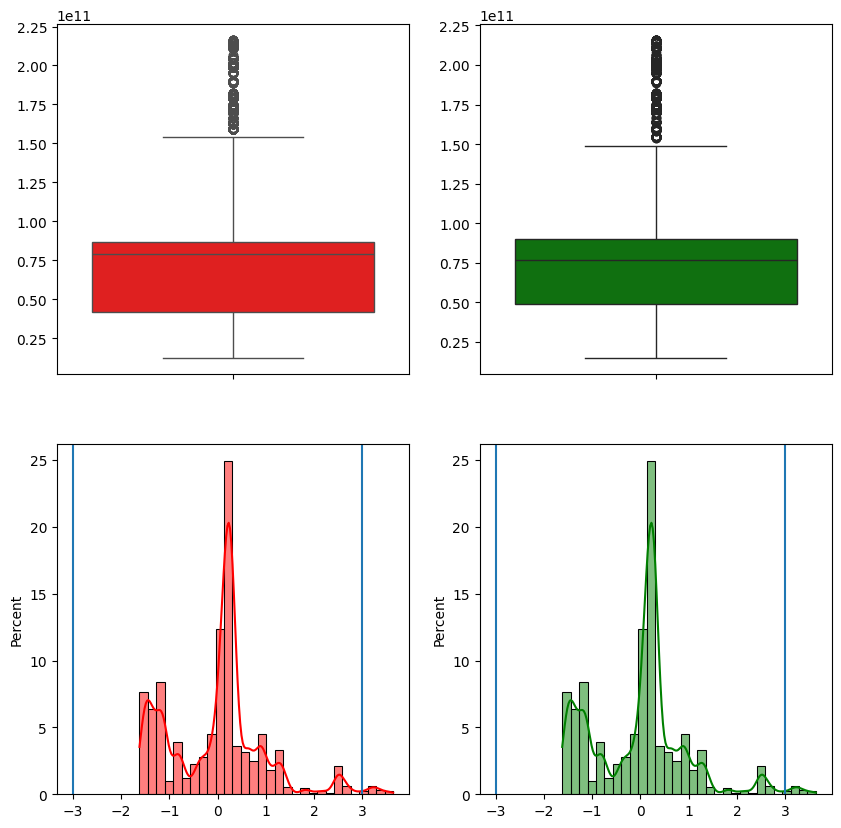

[0 0 0 ... 0 0 0]


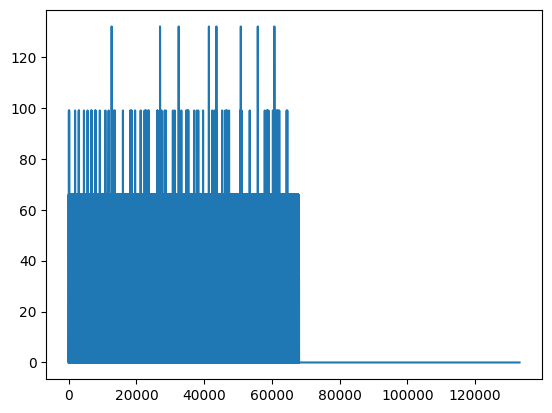

In [21]:
# separate the trojan and the benign data
Trojan_data = X_train[Y_train=="Trojan"]
Benign_data = X_train[Y_train=="Benign"]

# find the distance between each class mean and its points
voting = np.zeros(len(X_train), dtype=np.int32)
# calculate the mean of the data
trojan_mean = np.mean(Trojan_data, axis=0)
benign_mean = np.mean(Benign_data, axis=0)

# extract the distances for each class alone from its mean
distances_trojan = Trojan_data.apply(lambda row: math.dist(trojan_mean, row), axis=1)
distances_benign = Benign_data.apply(lambda row: math.dist(benign_mean, row), axis=1)

# plot distances for the 2 classes each on a graph
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
fig, ax = plt.subplots(2, 2, figsize=(10,10))


# plot for IQR range
sns.boxplot(distances_trojan, ax=ax[0][0], color="red")
sns.boxplot(distances_benign, ax=ax[0][1], color="green")

# compute quantiles
Q1 = distances_trojan.quantile(0.25)
Q3 = distances_trojan.quantile(0.75)
IQR = Q3 - Q1

# get which points to be removed and vote for it 
outliers = (distances_trojan < Q1 - IQR) | (distances_trojan > Q3 + IQR)

# vote for it if it's True
for index in np.where(outliers==True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it 
outliers = (distances_benign < Q1 - IQR) | (distances_benign > Q3 + IQR)

# vote for it if it's True
for index in np.where(outliers==True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)


# compute Z-score
# apply standard-scalar on each feature before plotting
distances0_normalized = StandardScaler().fit_transform(distances_trojan.values.reshape(-1, 1)).reshape(-1)
distances1_normalized = StandardScaler().fit_transform(distances_benign.values.reshape(-1, 1)).reshape(-1)

# get which points to be removed and vote for it (Benign)
outliers = (distances0_normalized < -3) | (distances0_normalized > 3)

# vote for it if it's True
for index in np.where(outliers == True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# get which points to be removed and vote for it (Benign)
outliers = (distances1_normalized < -3) | (distances1_normalized > 3)

# vote for it if it's True
for index in np.where(outliers == True):
    voting[index] += ((82 - len(indexes_of_columns_to_dropped)) // 2)

# plot the distribution of the distances
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][0], bins=30, color="red")
sns.histplot(distances0_normalized, stat="percent", kde=True, ax=ax[1][1], bins=30, color="green")

# plot the lines before which we will vote for the points to be outlier
ax[1][0].axvline(x=-3)
ax[1][1].axvline(x=-3)

# plot the lines after which we will vote for the points to be outlier
ax[1][0].axvline(x=3)
ax[1][1].axvline(x=3)

print(f"number of points in 1st cluster = {len(distances_trojan)}")
print(f"number of points in 2nd cluster = {len(distances_benign)}")

plt.show()

plt.plot(voting)
print(voting)

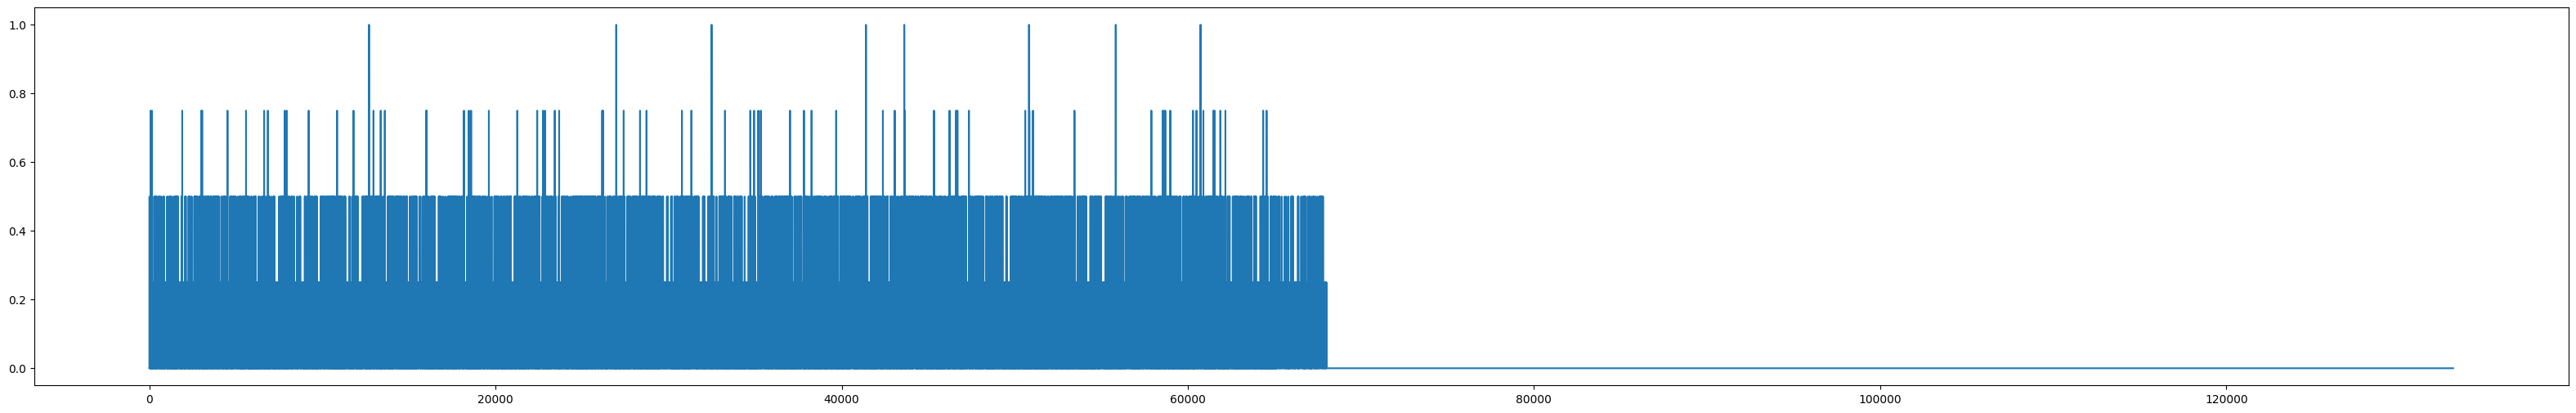

taking threshold for determining if it was an outlier or not with value 0.5 where if it's above that then it's an outlier
thus the number of points to be removed = 1663 and it's proportion of the training data = 1.2493332632164134%


In [50]:
# normalize voting
normalized_voting = voting / max(voting)

# get the indexes to be removed
outlier_threshold = 0.5
indexes_of_outliers_to_be_removed = np.where(normalized_voting >= 0.5)[0]

# plot the voting
plt.figure(figsize=(40,6))
plt.plot(normalized_voting)
plt.show()
print(f"taking threshold for determining if it was an outlier or not with value {outlier_threshold} where if it's above that then it's an outlier")
print(f"thus the number of points to be removed = {len(indexes_of_outliers_to_be_removed)} and it's proportion of the training data = {len(indexes_of_outliers_to_be_removed) * 100 / len(X_train)}%")

# remove the points
X_train.drop(indexes_of_outliers_to_be_removed, axis=0, inplace=True)
Y_train.drop(indexes_of_outliers_to_be_removed, axis=0, inplace=True)
# we couldn't use scatter-plot as scatter-plot can't visualize data points with more than 3 features (can be extended to 5 by using color and size as extra dimension representation but still we have around 80 features)


In [52]:
# calculate the mean and standard deviation of the training data
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

print(f"train mean = {train_mean}")
print(f"train standard deviation = {train_std}")

train mean = Source IP           2.335429e+10
Source Port         3.867690e+04
Destination IP      9.644030e+10
Destination Port    5.730142e+03
Protocol            8.291400e+00
                        ...     
Active Max          1.621919e+05
Active Min          1.268398e+05
Idle Mean           4.532275e+06
Idle Max            4.882308e+06
Idle Min            4.229717e+06
Length: 67, dtype: float64
train standard deviation = Source IP           4.245125e+10
Source Port         1.839604e+04
Destination IP      7.498911e+10
Destination Port    1.511430e+04
Protocol            4.537580e+00
                        ...     
Active Max          8.814648e+05
Active Min          7.568282e+05
Idle Mean           1.542443e+07
Idle Max            1.626183e+07
Idle Min            1.504839e+07
Length: 67, dtype: float64


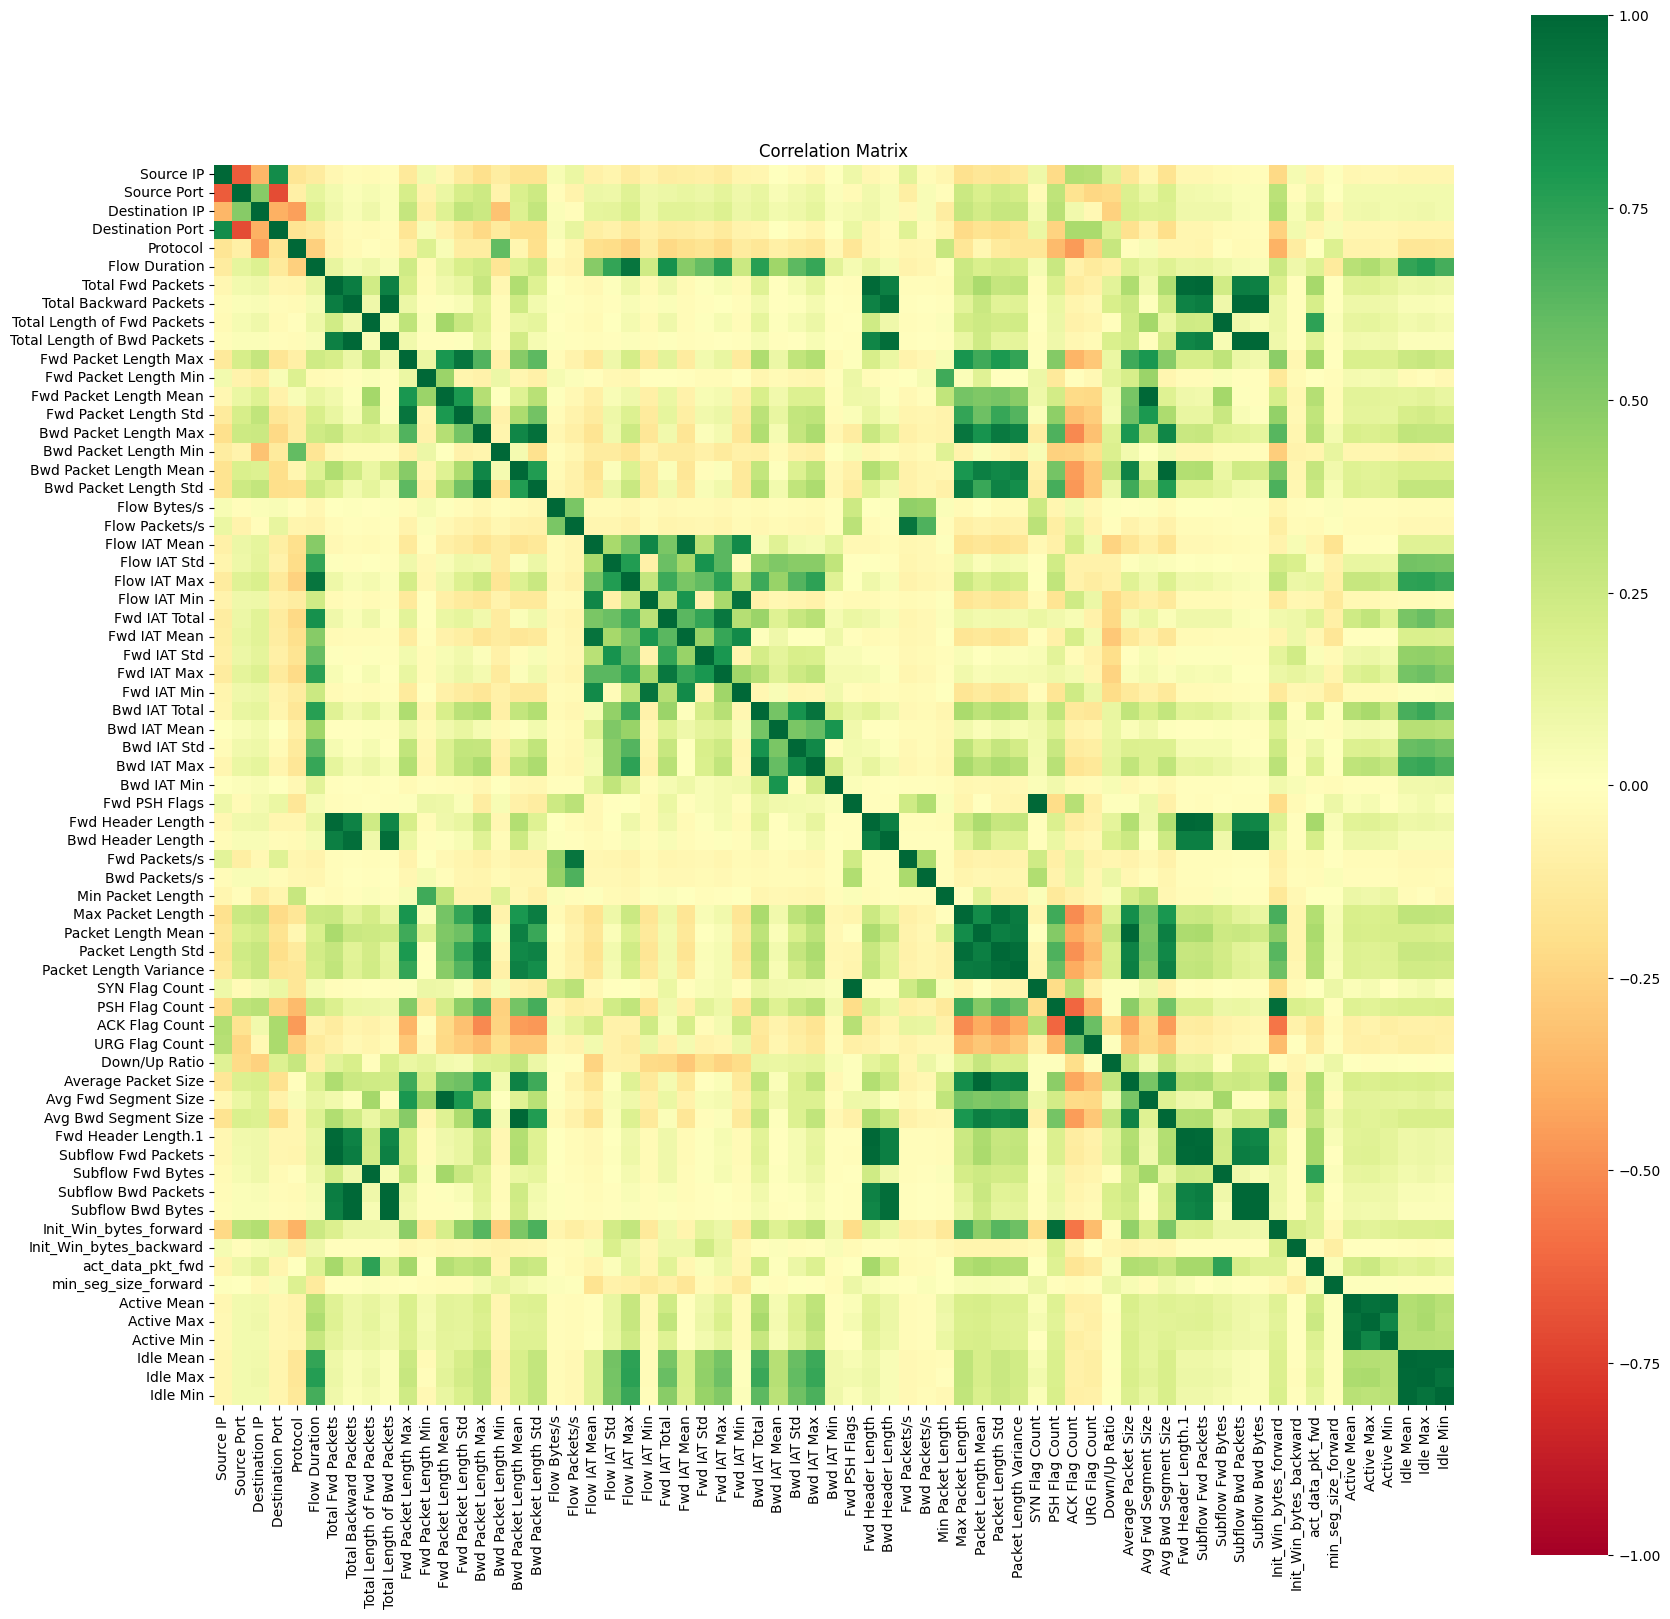

original variance ratio explained by each feature: [2.17200430e-01 1.28177565e-01 1.08276418e-01 6.13749327e-02
 5.40609446e-02 4.72000500e-02 4.01449994e-02 3.80357097e-02
 3.67429903e-02 2.91028239e-02 2.88173358e-02 2.62927429e-02
 2.18818860e-02 1.88573448e-02 1.56349316e-02 1.38562015e-02
 1.29750585e-02 1.11598288e-02 1.06538902e-02 8.98185752e-03
 7.62857482e-03 7.32533205e-03 6.47253241e-03 6.17409128e-03
 5.62521825e-03 5.15701327e-03 4.84938653e-03 4.40613075e-03
 3.45678560e-03 3.33221554e-03 2.76401912e-03 2.07292302e-03
 1.86133529e-03 1.43851940e-03 1.32551110e-03 1.08917467e-03
 8.87595626e-04 7.85847572e-04 6.94521060e-04 6.19962353e-04
 4.71833186e-04 4.34760409e-04 3.14368024e-04 2.88288029e-04
 2.53518794e-04 2.25208987e-04 1.80524181e-04 1.48910800e-04
 1.04992603e-04 5.61772991e-05 3.16356176e-05 3.10525501e-05
 1.71828616e-05 1.44724451e-05 1.29038562e-05 8.56622347e-06
 5.99004503e-06 4.98273147e-06 6.68053285e-23 1.10650392e-24
 4.28352320e-32 1.69799147e-32 1.0

In [65]:
# apply standard-scalar on the training data to make all of the feature have equal weights
scaled_features = X_train.apply(lambda x: (x- np.mean(x)) / np.std(x))  

# visualize correlation matrix of the training data after removing outliers and unneeded features
corr = scaled_features.corr()
_, ax = plt.subplots(figsize=(20, 20))
ax.set_title("Correlation Matrix")
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="RdYlGn", square=True, ax=ax)
plt.show()

# from the heatmap, we can notice that there is multiple feature having high positive correlation thus we can reduce dimensionality using PCA
analyze_pca = PCA().fit(scaled_features)
print(f"original variance ratio explained by each feature: {analyze_pca.explained_variance_ratio_} and total = {sum(analyze_pca.explained_variance_ratio_)}")

# keep only 95% of the variance. so select the dimension reduction value
cumulative_sum = np.cumsum(analyze_pca.explained_variance_ratio_)
print(f"cumulative sum of variance ratio = {cumulative_sum}")
new_dimension = np.argmin(np.abs(cumulative_sum - 0.95))
print(f"new number of dimensions = {new_dimension}")

# perform PCA reduction using new number of dimensions
reduce_pca = PCA(n_components=new_dimension).fit(scaled_features)
X_train = reduce_pca.transform(scaled_features)

In [77]:
# preprocess test data given the analysis we did on training data
def preprocess_test(X_test):
    
    # drop the features we decided to drop in analysis phase
    X_test.drop(X_test.columns[indexes_of_columns_to_dropped], axis=1, inplace=True)

    # apply IP format conversion 
    X_test['Source IP'] = X_test['Source IP'].apply(convertIP)
    X_test['Destination IP'] = X_test['Destination IP'].apply(convertIP)

    # apply standard-scalar equation on test data using mean and standard deviation of training data
    i = 0
    for series_name, series in X_test.items():
        X_test.iloc[series_name] = (X_test.iloc[series_name].values - train_mean[i]) / train_std[i]
        i += 1

    # apply dimension reduction using PCA of the training data
    reduced_test_data = reduce_pca.transform(X_test)
    return reduced_test_data

X_test = preprocess_test(X_test)
# X_test

array([[ 4.6543191 , -0.46549362, -1.92153684, ..., -0.22947568,
         0.35202855,  0.48276181],
       [-1.86630547,  1.28280211, -0.58358068, ..., -0.13247257,
         0.02094569, -0.05167269],
       [-2.14382393,  1.19037437, -0.38253236, ...,  0.01882047,
        -0.37200917,  0.20080621],
       ...,
       [-2.69031971,  0.66886739,  0.43193341, ..., -0.31471485,
        -0.06418482,  0.03957414],
       [-0.92253957, -1.25931645,  0.84681563, ..., -0.413304  ,
        -0.96633117,  0.4335769 ],
       [ 0.9329862 , -7.41589108,  4.91529758, ...,  0.27515693,
        -0.05792239, -0.07098289]])

In [4]:
def store_statistics(model):

    # train the model and calculate the time it takes to train
    start_time = time.time()
    model.fit(X_train, Y_train)
    train_time = round(time.time() - start_time, 2)

    # compute the time taken for the prediction 
    start_time = time.time()
    Y_pred = model.predict(X_test)
    predict_time = round(time.time() - start_time, 2)    
    
    # compute confusion matrix (ravel is numpy function to flatten the matrix)
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel() 
    
    # compute accuracy, recall, precision and F1-score
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = (2 * recall * precision) / (precision + recall) 

    # compute model size
    file = pickle.dumps(model)
    model_size = sys.getsizeof(file)

    # save AUC-ROC graph and get the name of the saved file
    graph_name = model.save_ROC_AUC_graph()

    # store confusion matrix in a string using pretty table
    table = PrettyTable()
    table.field_names = ["", "Trojan(Gold)", "Not Trojan(Gold)"]
    table.add_row(["Trojan(Pred)", tp, fp])
    table.add_row(["Not Trojan(Pred)", fn, tn])

    # open the file to write the results in a bench mark file
    with open("benchmark.txt", "a") as file:
        file.write( "=============================="
                    f"model Name: {model.getName()}"
                    "=============================="
                    f"best hyper parameters are:\n{model.getParameters()}\n"
                    "------------------------------"
                    "confusion matrix:\n"
                    f"{table.get_string()}"
                    "------------------------------"
                    f"Accuracy = {accuracy}"
                    f"Recall = {recall}"
                    f"Precision = {precision}"
                    f"F1-Score = {f1_score}"
                    f"Model Size = {model_size}"
                    f"Training Time = {train_time}"
                    f"Prediction Time = {predict_time}"
                    f"AUC-ROC graph Name = {graph_name}"
                    "------------------------------"
                    )



In [ ]:
# ZeroR classifier

# ZeroR uses Zero Features to predict, what is does is just get the most frequent class in the dataset and then predict any
# test point to be that most frequent class
class ZeroR():

    def __init__(self):
        pass

    # compute, Plot and Save AUC-ROC graph
    def save_ROC_AUC_graph(self):
        pass

    # return the name of the model
    def getName(self):
        return "ZeroR"

    # returns the hyperparameters of the model:
    def getParameters(self):
        return None

    # get the most frequent class
    # class list is a dictionary where they key is the class and value is the frequency of the class in the dataset
    def fit(self, X_features, Y_labels):
        self.model_Predicted = Counter(Y_labels).most_common(1)[0][0]
        print(Counter(Y_labels).most_common(2))

    # just return the most frequent class
    def predict(self, test):
        preprocess_test
        return self.model_Predicted

    # get the score of correctly predicting the classes
    def score(self, X_test, Y_test):
        return len(Y_test[Y_test == self.model_Predicted]) / len(Y_test)

zeroR = ZeroR()
zeroR.fit(X_train, Y_train)
print(zeroR.score(X_train, Y_train))
print(zeroR.score(X_test, Y_test))

# print(zeroR.predict(13321))
# print(Trojan_total)
# print(Benign_total)

[('Trojan', 63478), ('Benign', 60759)]
0.5109323316701239
0.5109427948195787


In [79]:
# logistic regression classifier

#
class Logistic_Regression():

    def __init__(self):
        # penalty:            Specify the norm of the penalty (regularization is applied by default)
        # dual:               Prefer dual=False when n_samples > n_features.
        # tol:                Tolerance for stopping criteria.
        # C:                  Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
        # fit_intercept:      Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
        # intercept_scaling:  Useful only when the solver ‘liblinear’ is used and self.fit_intercept is set to True.The intercept becomes intercept_scaling * synthetic_feature_weight.
        # class_weight:       Weights associated with classes in the form {class_label: weight}
        # random_state:       Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
        # solver:             Algorithm to use in the optimization problem.
        # max_iter:           Maximum number of iterations taken for the solvers to converge.
        # multi_class:        If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary.
        # verbose:            For the liblinear and lbfgs solvers set verbose to any positive number for verbosity.
        # warm_start:         When set to True, reuse the solution of the previous call to fit as initialization.
        # n_jobs:             Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”.
        # l1_ratio:           The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. the penalty is a combination of L1 and L2.
        self.model = LogisticRegression(penalty='l2', dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling= 1.0,
                                        class_weight=None, random_state=None, solver='newton-cg', max_iter=100,
                                        multi_class='ovr', verbose=0, warm_start=True, n_jobs=-1, l1_ratio=None)

    # train the model
    def fit(self, X_features, Y_labels):
        self.model.fit(X_features, Y_labels)

    # predict output
    def predict(self, X_test):
        return self.model.predict(X_test)

    # compute score
    def score(self, X_test, Y_test):
        return self.model.score(X_test, Y_test)



# logisticReg.fit(X_train, Y_train)
# print(logisticReg.score(X_test, Y_test))


0.5384598048274775


In [ ]:
# apply grid search CV on logistic regression to get the best hyper-parameters
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
logisticReg = Logistic_Regression()
# grid search cv uses KFold cross-validation to find the best match
search_result = GridSearchCV(estimator=logisticReg.model, param_grid=parameters, scoring='accuracy', n_jobs=-1, refit=True, cv=5, verbose=4, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)


In [ ]:
# decrease the window of the search to be around the optimal value we found so that we may found another optimal values

In [ ]:
# repeat the previous step again by decreasing the window again to get more of optimal value 

In [82]:
# Support Vector Machine classifier

# The implementation is based on libsvm.
class Support_Vector_Machine():

    def __init__(self):
        # C:                          Regularization parameter. The strength of the regularization is inversely proportional to C. The penalty is a squared l2 penalty.
        # kernel:                     Specifies the kernel type to be used in the algorithm.
        # degree:                     Degree of the polynomial kernel function (‘poly’).
        # gamma:                      Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
        # coef0:                      Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
        # shrinking:                  Whether to use the shrinking heuristic.
        # probability:                Whether to enable probability estimates.
        # tol:                        Tolerance for stopping criterion.
        # cache_size:                 Specify the size of the kernel cache (in MB).
        # class_weight:               Set the parameter C of class i to class_weight[i]*C for SVC.
        # verbose:                    Enable verbose output.
        # max_iter:                   Hard limit on iterations within solver, or -1 for no limit.
        # decision_function_shape:    Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2).
        # break_ties:                 If true, decision_function_shape='ovr', and number of classes > 2, predict will break ties according to the confidence values of decision_function; otherwise the first class among the tied classes is returned. Please note that breaking ties comes at a relatively high computational cost compared to a simple predict.
        # random_state:               Controls the pseudo random number generation for shuffling the data for probability estimates. Ignored when probability is False. Pass an int for reproducible output across multiple function calls.
        self.model = SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False,
                         tol=1e-3, cache_size=200, class_weight=None, verbose=False, max_iter=300,
                         decision_function_shape='ovr', break_ties=False, random_state=None)
    # train the model
    def fit(self, X_features, Y_labels):
        self.model.fit(X_features, Y_labels)

    # predict output
    def predict(self, X_test):
        return self.model.predict(X_test)

    # compute score
    def score(self, X_test, Y_test):
        return self.model.score(X_test, Y_test)

svm = Support_Vector_Machine()
svm.fit(X_train, Y_train)
print(svm.score(X_train, Y_train))
print(svm.score(X_test, Y_test))


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.5116776215689854
0.5116855603885421


In [ ]:
# Adaboost (Adaptive Boosting Classifier)


class Adaptive_Boosting_Classifier():

    def __init__(self):
        # estimator:       The base estimator from which the boosted ensemble is built. (in case estimator = None then the estimator is DecisionTreeClassifier initialized with max_depth=1.)
        # n_estimators:    The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
        # learning_rate:   Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier
        # algorithm:       If ‘SAMME.R’ then use the SAMME.R real boosting algorithm. estimator must support calculation of class probabilities. If ‘SAMME’ then use the SAMME discrete boosting algorithm. The SAMME.R algorithm typically converges faster than SAMME, achieving a lower test error with fewer boosting iterations.
        # random_state:    Controls the random seed given at each estimator at each boosting iteration.
        self.model = AdaBoostClassifier(estimator=None, n_estimators=50, learning_rate=0.5, algorithm="SAMME.R", random_state=0)
        
    # train the model
    def fit(self, X_features, Y_labels):
        self.model.fit(X_features, Y_labels)

    # predict output
    def predict(self, X_test):
        return self.model.predict(X_test)

    # compute score
    def score(self, X_test, Y_test):
        return self.model.score(X_test, Y_test)

48

In [ ]:
# TODO: plot learning curve for each model
# TODO: Grid search CV for each model (make grid search use cross validation)
# TODO: ROC-AUC graph for each model

67114


0.5425597849271956
